# SCG method for estimating RR

# Center sternum text file

In this notebook we are focusing on having the sensor placed on the sternum which is a good position to get the measures needed for estimating the RR rate.

In [1]:
import pandas as pd
import numpy as np

import pywt
from scipy.fftpack import fft,ifft,fftfreq
from scipy.signal import butter, lfilter, filtfilt, lfiltic , iirpeak, freqs, welch, iirfilter, hilbert

from scipy.signal import find_peaks, argrelextrema
from scipy.stats import norm, gamma, chi2, kurtosis, skew, stats

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

<b>Here we see that we have a frequency of 200Hz in the file so we need to reconfigure the timestamps by first converting them to integers then multiplying them with the frequency rate so we get reasonable timestamps. Then since we are doing SCG we are interested to look in the accelerometer and gyroscope values.</b>

Text(0, 0.5, 'Angular velocity [dps]')

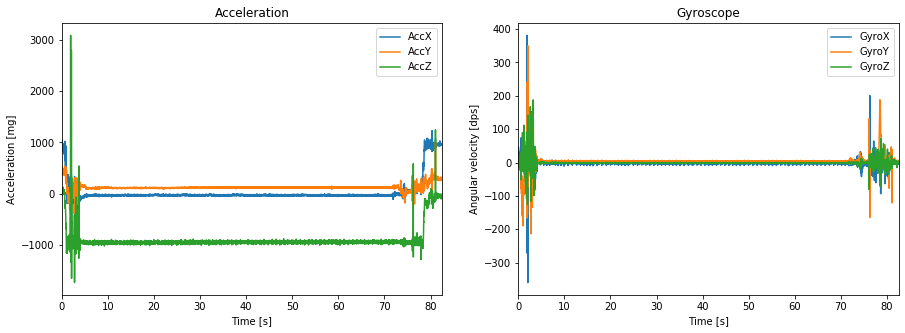

In [2]:
#Read data
sternumData = pd.read_csv('center_sternum.txt', sep='\t')

# Frequency of sternum Data
sternumFreq = sternumData['Log Freq'][1]              

# Reconstructing Real_Time
Time_stamp = sternumData['Timestamp']        
data_time = pd.DataFrame(np.asarray(range(len(Time_stamp)))*(1/sternumFreq), columns=['Timestamp'])

# Acc & Gyro data on the three axis
sternumData_ag = pd.concat([data_time,sternumData[['AccX','AccY','AccZ']], sternumData[['GyroX','GyroY','GyroZ']]],axis=1)

#Plot data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

AccPlot = sternumData_ag.plot(x='Timestamp', y=['AccX', 'AccY', 'AccZ'], kind='line', 
                    title='Acceleration', ax=axes[0])
AccPlot.set_xlabel('Time [s]')
AccPlot.set_ylabel('Acceleration [mg]')

gyroPlot = sternumData_ag.plot(x='Timestamp', y=['GyroX', 'GyroY', 'GyroZ'], kind='line', 
                    title='Gyroscope', ax=axes[1])
gyroPlot.set_xlabel('Time [s]')
gyroPlot.set_ylabel('Angular velocity [dps]')

<b>In the plot above we see that there is an extremely high noise in the beginning and end of the data. Therefore we choose a suitable time window to remove this noise and only focus on the relevant data. The extremely high noise probably comes from the positioning of the sensor. We choose our interval to be between second 10 to second 70.</b>

In [3]:
smallSternumData = sternumData_ag[(sternumData_ag['Timestamp'] >= 10) & (sternumData_ag['Timestamp'] < 70)]
describeData = smallSternumData.describe()
describeData = describeData.iloc[:,1:].round(2)
print(describeData)

           AccX      AccY      AccZ     GyroX     GyroY     GyroZ
count  12000.00  12000.00  12000.00  12000.00  12000.00  12000.00
mean     -30.67    115.57   -949.10     -2.08      3.68     -0.87
std        7.01      5.33     14.40      1.41      0.71      0.36
min      -66.92     85.83  -1015.53    -10.00      0.50     -2.50
25%      -35.26    112.06   -957.64     -2.69      3.28     -1.10
50%      -30.59    115.75   -949.53     -2.15      3.63     -0.85
75%      -25.99    119.07   -941.29     -1.48      4.00     -0.63
max       -5.43    147.38   -879.74      4.47      7.56      0.64


<b>In the table above we can see the characteristics and statistical information about our data. We can see that AccZ has a mean close to the gravity of earth which is </b>
\begin{align*}
g = 9.81m/s^2
\end{align*}
<b>The reason for this is because of the placement of the sensor being on the sternum since it is oriented in the Z axis. So we will have this in consideration going further, the standard deviation is also quite high. We can also see that AccX and AccY have similar statistics to each other and also that they have some kind of range between their values. Gyroscope attributes doesnt give us very much information so we will not focus as much on these features, it seems that there isnt very much rotation going on.</b>

# Fast Fourier Transform Analysis

<b>In the fast fourier transform analysis we can see that AccZ has very high peaks however the peaks are not high at the frequency of interest. Since we want to find respiratory rate we have a low frequency, usually below 1Hz. In the zoomed in version we can see that AccX have a very high peak at about 0.2Hz. For this reason we have chosen to continue with AccX as the feature to use. We also did a fourier transform on the gyroscope data but it didnt give us any information so we decided not to go with gyroscope data.</b>

Text(0.5, 0, 'Frequency [Hz]')

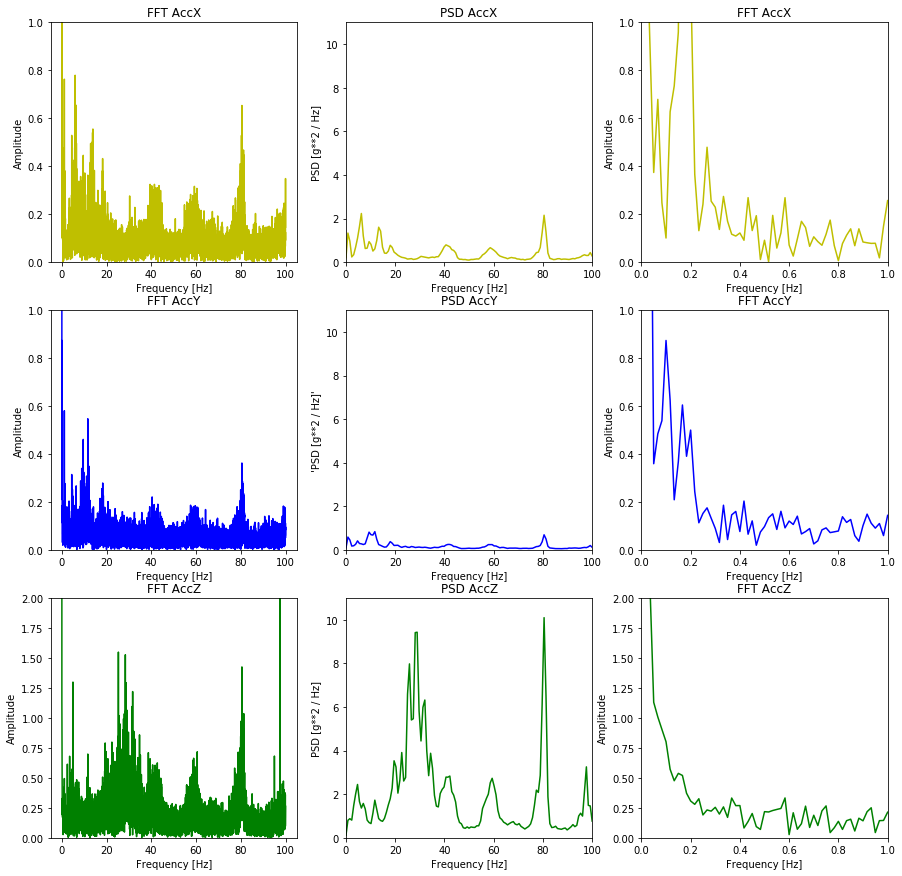

In [4]:
def fft_function(values, T, N):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      
    fft_values_ = fft(values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     
    return f_values, fft_values

def welch_function(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

#Fast Fourier Transform analysis
N = smallSternumData.shape[0]
T = 1/sternumFreq   
f_s = sternumFreq   

f_values, fft_values = fft_function(smallSternumData['AccX'], T, N)
f_values_psd, psd_values = welch_function(smallSternumData['AccX'], T, N, f_s)

f_values_y, fft_values_y = fft_function(smallSternumData['AccY'], T, N)
f_values_psd_y, psd_values_y = welch_function(smallSternumData['AccY'], T, N, f_s)

f_values_z, fft_values_z = fft_function(smallSternumData['AccZ'], T, N)
f_values_psd_z, psd_values_z = welch_function(smallSternumData['AccZ'], T, N, f_s)

#Plot Frequency domain/FFT data and welch signal
fig, axs = plt.subplots(3,3,figsize = (15,15))
axs[0,0].plot(f_values,fft_values,'y')
axs[0,0].set_title( "FFT AccX")
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel("Amplitude")
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,1].plot(f_values_psd, psd_values, linestyle='-', color='y')
axs[0,1].set_title("PSD AccX")
axs[0,1].axis([0,100,0,11])
axs[0,1].set_ylabel("PSD [g**2 / Hz]")
axs[0,1].set_xlabel('Frequency [Hz]')
axs[0,2].plot(f_values,fft_values,'y')
axs[0,2].set_title( "FFT AccX")
axs[0,2].set_ylim([0,1])
axs[0,2].set_xlim([0,1])
axs[0,2].set_ylabel("Amplitude")
axs[0,2].set_xlabel('Frequency [Hz]')

axs[1,0].plot(f_values_y,fft_values_y,'b')
axs[1,0].set_title( "FFT AccY")
axs[1,0].set_ylim([0,1])
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,1].plot(f_values_psd_y, psd_values_y, linestyle='-', color='b')
axs[1,1].axis([0,100,0,11])
axs[1,1].set_title("PSD AccY")
axs[1,1].set_ylabel("'PSD [g**2 / Hz]'")
axs[1,1].set_xlabel('Frequency [Hz]')
axs[1,2].plot(f_values_y,fft_values_y,'b')
axs[1,2].set_title( "FFT AccY")
axs[1,2].set_ylim([0,1])
axs[1,2].set_xlim([0,1])
axs[1,2].set_ylabel("Amplitude")
axs[1,2].set_xlabel('Frequency [Hz]')

axs[2,0].plot(f_values_z,fft_values_z,'g')
axs[2,0].set_title( "FFT AccZ")
axs[2,0].set_ylim([0,2])
axs[2,0].set_ylabel("Amplitude")
axs[2,0].set_xlabel('Frequency [Hz]')
axs[2,1].plot(f_values_psd_z, psd_values_z, linestyle='-', color='g')
axs[2,1].set_title("PSD AccZ")
axs[2,1].axis([0,100,0,11])
axs[2,1].set_ylabel("PSD [g**2 / Hz]")
axs[2,1].set_xlabel('Frequency [Hz]')
axs[2,2].plot(f_values_z,fft_values_z,'g')
axs[2,2].set_title( "FFT AccZ")
axs[2,2].set_ylim([0,2])
axs[2,2].set_xlim([0,1])
axs[2,2].set_ylabel("Amplitude")
axs[2,2].set_xlabel('Frequency [Hz]')

# Filter signal
<b>In the block below we filter our signal. We tried with a bandpass filter with a frequency range of 0.1-0.5 but it didnt give us any valueable information. Then we tried with a low pass filter because we are interested in very low frequencys so we wanted to filter out everything above 0.4. With the low pass filter we achieved a good signal that we could use to estimate respiratory rate by looking at the high peaks of the signal on the X axis. We also tried looking at the Z axis but it didnt give us as good signal as compared to the X axis, but because of the statistical analysis we decided to try with the Z axis also.</b>

Text(0.5, 1.0, 'AccX')

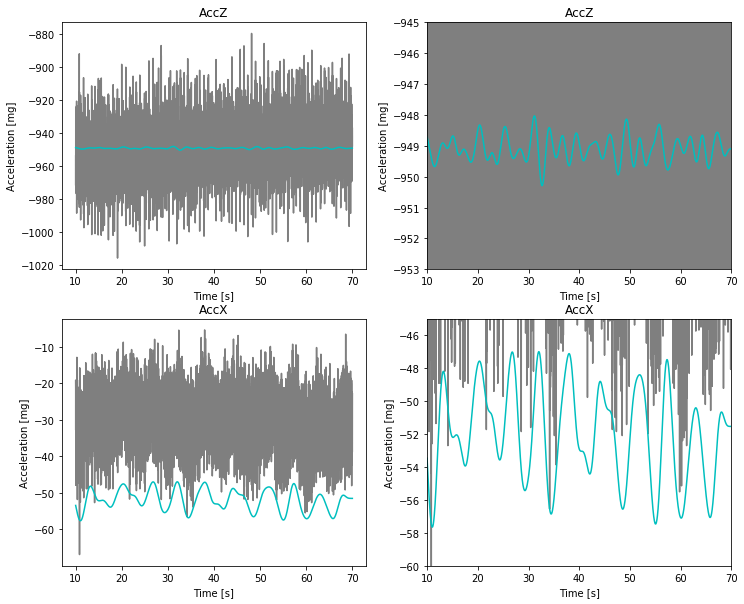

In [5]:
def butterFilter(filter_order, frequency_in, filter_type ,sampling_freq_system, data_in):
    b,a = butter(filter_order,frequency_in, filter_type, fs = sampling_freq_system)
    frequency_responsew,h = freqs(b,a)
    data_filtered = filtfilt(b,a, data_in) 
    return data_filtered

def iir_filter(filter_order, frequency_in, design, data_in, sampling_freq_system):
    b,a = iirfilter(filter_order,frequency_in, ftype=design, fs=sampling_freq_system)
    data_filtered = filtfilt(b,a, data_in)
    return data_filtered

#Mean value of AccX
mean_amplitude_AccZ = smallSternumData[['AccZ']].mean()[0]
mean_amplitude_AccX = smallSternumData[['AccX']].mean()[0]

#Filter on AccX
#result = iir_filter(3, [0.15,0.45] , 'band', smallSternumData['AccZ'], sternumFreq)
resultAccZ = butterFilter(3, [0.15,0.45], 'band', 200, smallSternumData['AccZ'])
resultAccX = butterFilter(7, 0.4 , 'low', 200, smallSternumData['AccX'])

#Plot of the filter
fig, axes = plt.subplots(2,2,figsize = (12,10))

axes[0,0].plot(smallSternumData['Timestamp'], smallSternumData['AccZ'],'k', alpha=0.5)
axes[0,0].plot(smallSternumData['Timestamp'], resultAccZ + mean_amplitude_AccZ,'c',label='Band filter 0.15-0.45Hz')
axes[0,0].set_ylabel("Acceleration [mg]")
axes[0,0].set_xlabel('Time [s]')
axes[0,0].set_title('AccZ')

#Plot of zoomed in data
axes[0,1].plot(smallSternumData['Timestamp'], smallSternumData['AccZ'],'k', alpha=0.5)
axes[0,1].plot(smallSternumData['Timestamp'], resultAccZ + mean_amplitude_AccZ,'c',label='Band filter 0.15-0.45Hz')
axes[0,1].set_xlim([10,70])
axes[0,1].set_ylim([-953,-945])
axes[0,1].set_ylabel("Acceleration [mg]")
axes[0,1].set_xlabel('Time [s]')
axes[0,1].set_title('AccZ')

axes[1,0].plot(smallSternumData['Timestamp'], smallSternumData['AccX'],'k', alpha=0.5)
axes[1,0].plot(smallSternumData['Timestamp'], resultAccX + mean_amplitude_AccX,'c',label='Low filter < 0.4Hz')
axes[1,0].set_ylabel("Acceleration [mg]")
axes[1,0].set_xlabel('Time [s]')
axes[1,0].set_title('AccX')

#Plot of zoomed in data
axes[1,1].plot(smallSternumData['Timestamp'], smallSternumData['AccX'],'k', alpha=0.5)
axes[1,1].plot(smallSternumData['Timestamp'], resultAccX + mean_amplitude_AccX,'c',label='Low filter < 0.4Hz')
axes[1,1].set_xlim([10,70])
axes[1,1].set_ylim([-60,-45])
axes[1,1].set_ylabel("Acceleration [mg]")
axes[1,1].set_xlabel('Time [s]')
axes[1,1].set_title('AccX')

# Hilbert transform

**By applying the *Hilbert* transform to the filtered signal we obtain a smooth curve outlining its extremes. What is obtained by this, is that the function plots just the amplitude values of the filtered spectrum. The envelope thus generalizes the concept of a constant amplitude into an instantaneous amplitude, which has turned out to be really useful.**

**For this, *pandas* provides the *hilbert()* function, used to apply that certain trasform. Is defined as the transform in which phase angle of all components of the signal is shifted by $\pm 90º$, obtaining the amplitude of the wave train in function of time. The Hilbert transform is important in signal processing, where it derives the analytic representation of a real-valued signal.**

**Looking at the image obtained in the cell below, we can observe that the function goes from the amplitude of a wave to the amplitude of the next one. The center of a single wave packet is extracted, which periodically shows up.**

<img src = "figure1.png">

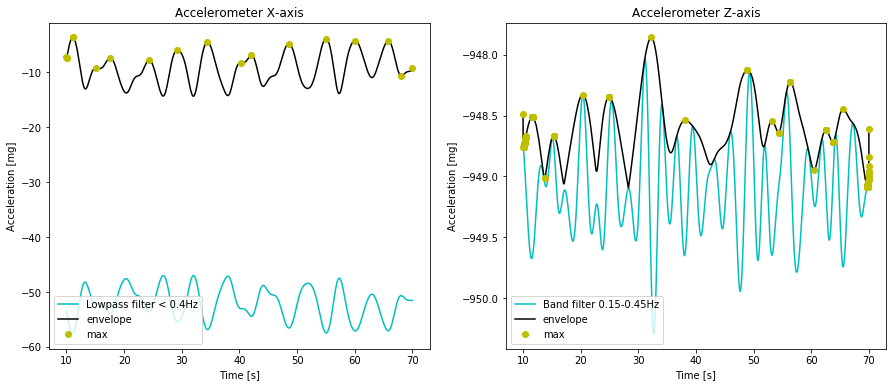

In [6]:
def maxima_minima(time, filtereddata):
    filterData = pd.DataFrame({'Time':time, 'Filtered':filtereddata})
    filterData['min'] = filterData.iloc[argrelextrema(filterData.Filtered.values, np.less_equal, order=1)[0]]['Filtered']
    filterData['max'] = filterData.iloc[argrelextrema(filterData.Filtered.values, np.greater_equal, order=1)[0]]['Filtered']
    return filterData

hilbertTransformAccX = hilbert(resultAccX)
amplitude_envelope_AccX = np.abs(hilbertTransformAccX)

max_min_AccX = maxima_minima(smallSternumData['Timestamp'], amplitude_envelope_AccX + mean_amplitude_AccX)

hilbertTransformAccZ = hilbert(resultAccZ)
amplitude_envelope_AccZ = np.abs(hilbertTransformAccZ)

max_min_AccZ = maxima_minima(smallSternumData['Timestamp'], amplitude_envelope_AccZ + mean_amplitude_AccZ)

fig, axes = plt.subplots(1,2,figsize = (15,6))

axes[0].plot(smallSternumData['Timestamp'], resultAccX + mean_amplitude_AccX,'c', label='Lowpass filter < 0.4Hz')
axes[0].plot(smallSternumData['Timestamp'], amplitude_envelope_AccX+mean_amplitude_AccX,'k',label='envelope')
axes[0].plot(max_min_AccX['Time'], max_min_AccX['max'],'yo',label='max')
axes[0].set_ylabel("Acceleration [mg]")
axes[0].set_xlabel('Time [s]')
axes[0].set_title('Accelerometer X-axis')
axes[0].legend(loc='lower left')

axes[1].plot(smallSternumData['Timestamp'], resultAccZ + mean_amplitude_AccZ,'c', label='Band filter 0.15-0.45Hz')
axes[1].plot(smallSternumData['Timestamp'], amplitude_envelope_AccZ+mean_amplitude_AccZ,'k',label='envelope')
axes[1].plot(max_min_AccZ['Time'], max_min_AccZ['max'],'yo',label='max')
axes[1].set_ylabel("Acceleration [mg]")
axes[1].set_xlabel('Time [s]')
axes[1].set_title('Accelerometer Z-axis')
axes[1].legend(loc='lower left')

plt.show()
plt.close()

# Maximum peaks

**In order to obtain the BPM estimation, the time difference between the respective peaks of the envelope function needs to be obtained. Having every difference permits to obtain the mean, which will give us what we are looking for. The *find_max()* function has been implemented for that, taking advantage of the *diff()* function provided by *pandas* which computes the difference between the current row and the one before. As we are interested in every peak, the values of those do not have to be limited. However, as the are many rows with no 'max' value, a *None* value will fill that cell so the *dropna()* function helps to remove those rows. We also use a threshold to remove some unwanted peaks that is seen on the signal**

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

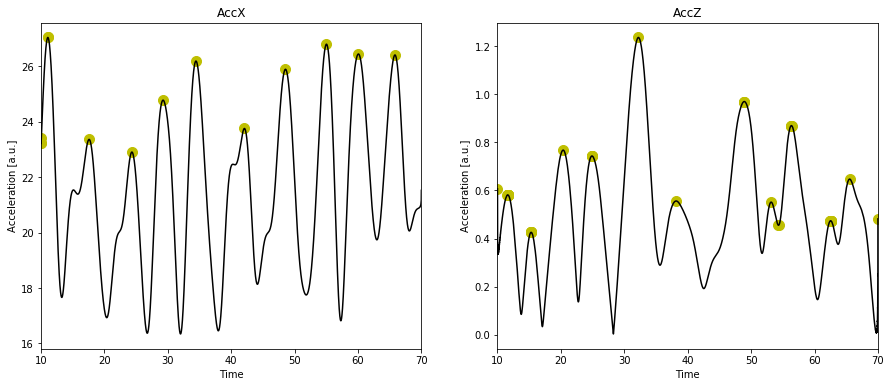

In [7]:
def find_min(filterData):
    time_max_array = filterData[['Time', 'min']]
    value_best = time_max_array.dropna() 
    difference = value_best.diff()
    return difference.dropna()
    
def find_max(filterData):
    time_max_array = filterData[['Time', 'max']]
    value_best = time_max_array.dropna()
    difference = value_best.diff()
    return difference.dropna()

FilteredAccX = pd.DataFrame([smallSternumData['Timestamp'].values, resultAccX, amplitude_envelope_AccX]).T
FilteredAccX.columns = ["Time","AccX","Amp_envelope"]

FilteredAccZ = pd.DataFrame([smallSternumData['Timestamp'].values, resultAccZ, amplitude_envelope_AccZ]).T
FilteredAccZ.columns = ["Time","AccZ","Amp_envelope"]

threshold = 22.8
fig = plt.figure(figsize=(12,4))
thresholdValuesAccX = FilteredAccX[(FilteredAccX['Amp_envelope'] >= threshold)]
thresholdMaxMinAccX = maxima_minima(thresholdValuesAccX['Time'].values, thresholdValuesAccX['Amp_envelope'].values)

threshold = 0.425
fig = plt.figure(figsize=(12,4))
thresholdValuesAccZ = FilteredAccZ[(FilteredAccZ['Amp_envelope'] >= threshold)]
thresholdMaxMinAccZ = maxima_minima(thresholdValuesAccZ['Time'].values, thresholdValuesAccZ['Amp_envelope'].values)

maximaAccX = thresholdMaxMinAccX[['Time','max']].dropna()
minimaAccX = thresholdMaxMinAccX[['Time', 'min']].dropna()
maximaAccZ = thresholdMaxMinAccZ[['Time','max']].dropna()
minimaAccZ = thresholdMaxMinAccZ[['Time','min']].dropna()

timeDiffMinAccX = find_min(minimaAccX)
timeDiffMaxAccX = find_max(maximaAccX)
timeDiffMinAccX = timeDiffMinAccX[(timeDiffMinAccX['Time'] > 0.011)]
timeDiffMaxAccX = timeDiffMaxAccX[(timeDiffMaxAccX['Time'] > 0.011)]
timeDiffMinAccZ = find_min(minimaAccZ)
timeDiffMaxAccZ = find_max(maximaAccZ)
timeDiffMinAccZ = timeDiffMinAccZ[(timeDiffMinAccZ['Time'] > 0.011)]
timeDiffMaxAccZ = timeDiffMaxAccZ[(timeDiffMaxAccZ['Time'] > 0.011)]

fig, axes = plt.subplots(1,2,figsize = (15,6))

axes[0].plot(maximaAccX['Time'], maximaAccX['max'], 'yo', markersize = 10)
axes[0].plot(FilteredAccX['Time'],FilteredAccX["Amp_envelope"],'k',label='envelope')
axes[0].set_xlim([10,70])
axes[0].set_ylabel('Acceleration [a.u.]')
axes[0].set_xlabel("Time")
axes[0].set_title("AccX")

axes[1].plot(maximaAccZ['Time'], maximaAccZ['max'], 'yo', markersize = 10)
axes[1].plot(FilteredAccZ['Time'],FilteredAccZ["Amp_envelope"],'k',label='envelope')
axes[1].set_xlim([10,70])
axes[1].set_ylabel('Acceleration [a.u.]')
axes[1].set_xlabel("Time")
axes[1].set_title("AccZ")

plt.show()

# Times distribution between the high peaks

**The extrapolated respiration rate estimation is plotted into a histogram regarding the time difference between respective peaks. Firstly, the number of bins used has been 6 due to the fact that if we look at the differences, they are pretty close to each other, mostly. Besides, the hypothetical gaussian distributionhas been plotted, and it is noticeable that the time distribution does kind of follow it on the distribution for the X axis, besides one value that is around 2. This lowers the average time difference between respirations. The principal reason of this unexpected value is the appearence of the noise which modifies the signal. The times distribution for the Z axis looks like a uniform distribution except for the value which is around 10**

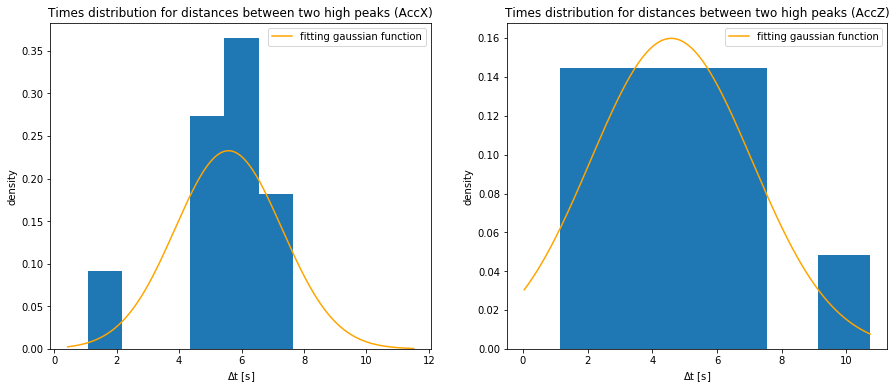

In [8]:
mu_maxAccX, sigma_maxAccX = norm.fit(timeDiffMaxAccX['Time'].values)
gauss_maxAccX = norm(loc = mu_maxAccX, scale = sigma_maxAccX)

xAccX = np.arange( min(min(timeDiffMaxAccX['Time'].values), min(timeDiffMinAccX['Time'].values)), 
              max(max(timeDiffMaxAccX['Time'].values), max(timeDiffMinAccX['Time'].values)) + 0.01, 0.01)

mu_maxAccZ, sigma_maxAccZ = norm.fit(timeDiffMaxAccZ['Time'].values)
gauss_maxAccZ = norm(loc = mu_maxAccZ, scale = sigma_maxAccZ)

xAccZ = np.arange( min(min(timeDiffMaxAccZ['Time'].values), min(timeDiffMinAccZ['Time'].values)), 
              max(max(timeDiffMaxAccZ['Time'].values), max(timeDiffMinAccZ['Time'].values)) + 0.01, 0.01)

fig, axes = plt.subplots(1,2,figsize = (15,6))

axes[0].hist(timeDiffMaxAccX['Time'].values, bins = 6, density = True)
axes[0].plot(xAccX, gauss_maxAccX.pdf(xAccX), color = 'orange',  label = "fitting gaussian function")
axes[0].set_title("Times distribution for distances between two high peaks (AccX)")
axes[0].set_xlabel("$\Delta$t [s]")
axes[0].set_ylabel("density")
axes[0].legend()

axes[1].hist(timeDiffMaxAccZ['Time'].values, bins = 6, density = True)
axes[1].plot(xAccZ, gauss_maxAccZ.pdf(xAccZ), color = 'orange',  label = "fitting gaussian function")
axes[1].set_title("Times distribution for distances between two high peaks (AccZ)")
axes[1].set_xlabel("$\Delta$t [s]")
axes[1].set_ylabel("density")
axes[1].legend()

plt.show()

# Respiratory rate calculation

**Due to the fact of what mentioned before, the estimated average BPM obtained is $10.752$ and its standard deviation $3.3$ for the X axis. The BPM for AccZ is $13.08$ and the standard deviation $7.117$. The high value for the standard deviation on the Z axis is pretty high because of the value 10 and since the signal is not as clear as the signal from the X axis.
We already know, after researching in various reliable webpages around the internet, that the number of times an adult breaths when resting is about 8-16 breaths per minute. This is found on the website MedlinePlus and it is what we approximately expected to obtain. Being every value except one concentrated in a small range of the histogram seems logical to us, since the time between respiration tends to be regular when resting. Our result of 10.7 and 13.08 makes sense with the average respiratory rate from the website**

In [9]:
miAccX = np.mean(timeDiffMaxAccX['Time'].values)
sigma_x_AccX = np.std(timeDiffMaxAccX['Time'].values)
print(miAccX, ' ', sigma_x_AccX)

miAccZ = np.mean(timeDiffMaxAccZ['Time'].values)
sigma_x_AccZ = np.std(timeDiffMaxAccZ['Time'].values)
print(miAccZ, ' ', sigma_x_AccZ)

print('The std of BPM (AccX)',(60/(miAccX)**2)*sigma_x_AccX)
print('BPM (AccX):', 60/miAccX)

print('The std of BPM (AccZ)',(60/(miAccZ)**2)*sigma_x_AccZ)
print('BPM (AccZ):', 60/miAccZ)

5.58   1.713677332522082
4.586538461538461   2.4955617408445074
The std of BPM (AccX) 3.3022648717040157
BPM (AccX): 10.75268817204301
The std of BPM (AccZ) 7.1178607884641165
BPM (AccZ): 13.08176100628931


# Respiratory rate variability

**The respiration rate variability, also known as *RRV*, is the physiological phenomenon of variation in the time interval between breaths. It is measured by the variation in the breath-to-breath interval. By the application of this we analyse how the time between respective high peaks change along one minute. For instance, the histogram plotted before gives us an idea of this concept, since the densities for time between peaks are computed. However, the relation between respective peaks has been not taken into account, which is shown in the following cell. What this *scatter* plot tells us is, that respective peaks is kind of linear but since the standard deviation was pretty high, they are also scattered all around the line. The standard deviation should be lower since we assume that the person is resting. When compared with the subject lying on the matress, the standard deviation is less which might have to do with it being less noise since the person is lying down.**

**The variability for the X axis is a bit better but it is expected when looking at the standard deviation fom before. We can see that the values are quite close to each other except for 1 value. However in the Z axis the plots are quite randomly distributed because of the high standard deviation.**

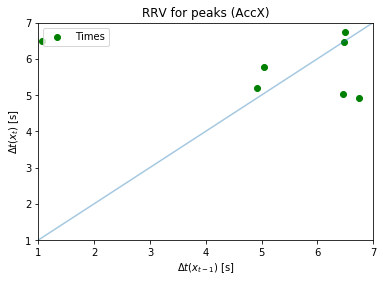

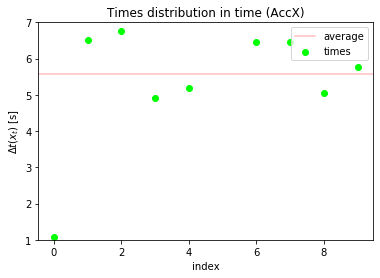

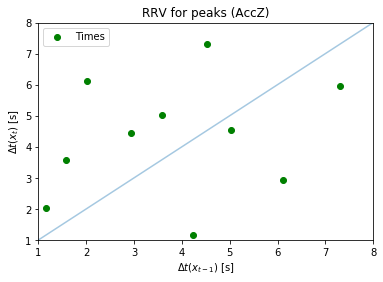

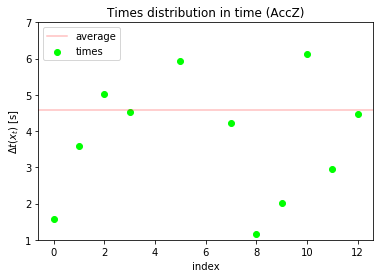

In [10]:
xAccX = np.linspace(0.2, max(timeDiffMaxAccX['Time'])+ 0.1 , 100)
xAccZ = np.linspace(0.2, max(timeDiffMaxAccZ['Time'])+ 0.1 , 100)

plt.scatter(timeDiffMaxAccX['Time'].values[:-1], timeDiffMaxAccX['Time'].values[1:], color = 'g', label = "Times")
plt.title("RRV for peaks (AccX)")
plt.xlabel("$\Delta t (x_{t-1})$ [s]")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.plot(xAccX,xAccX, alpha=0.4)
plt.xlim([1,7])
plt.ylim([1,7])
plt.legend()
plt.plot()
plt.show()


plt.scatter(np.arange(len(timeDiffMaxAccX['Time'].values)), timeDiffMaxAccX['Time'].values, color = 'lime', label = "times")
plt.axhline(np.mean(timeDiffMaxAccX['Time'].values), color = 'red', alpha = 0.25, label = 'average')
plt.title("Times distribution in time (AccX)")
plt.xlabel("index")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.ylim([1,7])
plt.legend()
plt.plot()
plt.show()

plt.scatter(timeDiffMaxAccZ['Time'].values[:-1], timeDiffMaxAccZ['Time'].values[1:], color = 'g', label = "Times")
plt.title("RRV for peaks (AccZ)")
plt.xlabel("$\Delta t (x_{t-1})$ [s]")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.plot(xAccZ,xAccZ, alpha=0.4)
plt.xlim([1,8])
plt.ylim([1,8])
plt.legend()
plt.plot()
plt.show()

plt.scatter(np.arange(len(timeDiffMaxAccZ['Time'].values)), timeDiffMaxAccZ['Time'].values, color = 'lime', label = "times")
plt.axhline(np.mean(timeDiffMaxAccZ['Time'].values), color = 'red', alpha = 0.25, label = 'average')
plt.title("Times distribution in time (AccZ)")
plt.xlabel("index")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.ylim([1,7])
plt.legend()
plt.plot()
plt.show()